# Temporal Plots of DESI Telemetry Data

As is, the DESI telemetry data is spread out across multiple different tables. As is is shown in the correlations plots in the `correlation` folder, there us very weak correlation across different tables. Before proper analysis can be done, the several datatables of interest must 
be syncronized in time. This involves rebinning and interpolation of the data is currently being hosted by NERSC.

## Imports

In [17]:
import os
from tqdm.notebook import trange, tqdm
import pytz
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from scipy.stats import norm, skewnorm, zscore
from astropy.stats import scott_bin_width
from math import trunc, ceil, floor

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('tableau-colorblind10')

import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from astropy.timeseries import aggregate_downsample, TimeSeries
import astropy.units as u

try:
    import numba as nb
    nb.cuda.detect()
    import cupy as cp
    %pip install -q cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
    import cudf as cd
    gpu_access = True
except:
    gpu_access = False
    print('No GPU devices available!')
data_dir = '../../py/desiforecast/data'
if not os.path.isdir(data_dir):
    data_dir = 'py/desiforecast/data'

No GPU devices available!


## Load Data

In [19]:
tower_data = TimeSeries.read(f'{data_dir}/environmentmonitor_tower.fits')
dome_data = TimeSeries.read(f'{data_dir}/environmentmonitor_dome.fits')
telescope_data = TimeSeries.read(f'{data_dir}/environmentmonitor_telescope.fits')
seeing_data = TimeSeries.read(f'{data_dir}/etc_seeing.fits')
telemetry_data = TimeSeries.read(f'{data_dir}/etc_telemetry.fits')
tcs_data = TimeSeries.read(f'{data_dir}/tcs_info.fits')

In [36]:
# Original, unfiltered data as provided by the DESI telemetry database
with open(f'{data_dir}/environmentmonitor_tower.pkl', 'rb') as pf:
    tower_data = pd.read_pickle(pf)
with open(f'{data_dir}/environmentmonitor_dome.pkl', 'rb') as pf:
    dome_data = pd.read_pickle(pf)
with open(f'{data_dir}/environmentmonitor_telescope.pkl', 'rb') as pf:
    telescope_data = pd.read_pickle(pf)
    telescope_data['mirror_cooling'] = telescope_data['mirror_cooling'].interpolate(limit_direction='both')
with open(f'{data_dir}/etc_seeing.pkl', 'rb') as pf:
    seeing_data = pd.read_pickle(pf)
with open(f'{data_dir}/etc_telemetry.pkl', 'rb') as pf:
    telemetry_data = pd.read_pickle(pf)
with open(f'{data_dir}/tcs_info.pkl', 'rb') as pf:
    tcs_data = pd.read_pickle(pf)
# with open(f'{data_dir}/temp_delta_stats_daytime.pkl', 'rb') as pf:
#     daytime_delta_stats_data = pd.read_pickle(pf)
# with open(f'{data_dir}/temp_delta_stats_nighttime.pkl', 'rb') as pf:
#     nighttime_delta_stats_data = pd.read_pickle(pf)
# with open(f'{data_dir}/temp_delta_stats_nighttime.pkl', 'rb') as pf:
#     nighttime_delta_stats_data = pd.read_pickle(pf)
# with open(f'{data_dir}/full_distributions_daytime.pkl', 'rb') as pf:
#     full_distributions_daytime = pd.read_pickle(pf)
# with open(f'{data_dir}/full_distributions_nighttime.pkl', 'rb') as pf:
#     full_distributions_nighttime = pd.read_pickle(pf)

In [ ]:
with open(f'{data_dir}/ambient_distributions_daytime.pkl', 'rb') as pf:
    ambient = pd.read_pickle(pf)
with open(f'{data_dir}/delta_distributions_daytime.pkl', 'rb') as pf:
    delta = pd.read_pickle(pf)

In [39]:
def valid_values(data):
    data = np.asarray(data)
    arr = np.full((len(data)), False, dtype=bool)
    std = np.std(data[np.isfinite(data)])
    mean = np.mean(data[np.isfinite(data)])
    for i in range(len(data)):
        if np.isfinite(data[i]) and np.abs((data[i]-mean)/std) < 5:
            arr[i] = True
    return arr

def response_time_plots(daytime=True, outliers=False):
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    mpl.style.use('tableau-colorblind10')

    folder = 'daytime' if daytime else 'nighttime'
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    
    with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
        temp_delta_data = pickle.load(pf)
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)

    vmin=temp_delta_data['ambient_start'][valid_values(temp_delta_data['ambient_start'])].min()
    vmax=temp_delta_data['ambient_start'][valid_values(temp_delta_data['ambient_start'])].max()
    
    xmin=temp_delta_data['ambient_std'][valid_values(temp_delta_data['ambient_std'])].min()
    xmax=temp_delta_data['ambient_std'][valid_values(temp_delta_data['ambient_std'])].max()
    
    ymin=temp_delta_data['response_time'][valid_values(temp_delta_data['response_time'])].min()
    ymax=temp_delta_data['response_time'][valid_values(temp_delta_data['response_time'])].max()
    
    temp_stats = {}
    for i in years:
        year = {}
        for j in months:
            year[j] = []
        temp_stats[i] = year

    for i in range(len(temp_delta_data)):
        temp_stats[temp_delta_data.index[i].year][temp_delta_data.index[i].month].append(temp_delta_data.iloc[i])
    
    median_response = []
    mean_response = []
    std_response = []
    date = []
    
    for i in years:
        directory = f'doc/nb/time_plots/response_time/{i}'
        for j in tqdm(months, desc=f'{i}'):
            df = pd.DataFrame(temp_stats[i][j])
            if 'ambient_response' and 'ambient_start' and 'ambient_std' in df.columns.values:
                if not os.path.isdir(directory):
                    os.makedirs(directory)
                
                fig, ax = plt.subplots(ncols=2, figsize=(20,5))

                var_indx = valid_values(df['ambient_std'])
                response_indx = valid_values(df['response_time'])
                start_indx = valid_values(df['ambient_start'])
                indx = np.logical_and(var_indx, np.logical_and(response_indx, start_indx))
                
                median_response.append(np.median(df['response_time'][indx]))
                mean_response.append(np.mean(df['response_time'][indx]))
                std_response.append(np.std(df['response_time'][indx]))
                date.append(pd.Timestamp(year=i, month=j, day=1))
                
                plot = ax[0].scatter(df['ambient_std'][indx], df['response_time'][indx], c=df['ambient_start'][indx], vmin=vmin, vmax=vmax)
                ax[0].set_title(f'Response Time vs. Standard Deviation of Ambient Temperature ({i}-{j})')
                ax[0].set_ylabel('Response Time (Hrs)')
                ax[0].set_ylim(ymin, ymax)
                ax[0].set_xlabel(u'Standard Deviation of Ambient Temperature (\u2103)')
                ax[0].set_xlim(xmin, xmax)
                ax[0].grid(True)
                fig.colorbar(plot, ax=ax[0], label=u'Initial Ambient Temperature (\u2103)')
                
                bins = ceil(np.ptp(df['response_time'][indx])/scott_bin_width(df['response_time'][indx]))
                # bins = ceil(4*np.ptp(ambient_arr))
                ax[1].hist(df['response_time'][indx], bins=bins, density=True, label='histogram')
                xs = np.linspace(0, 24, 1000*(24)+1)
                ys = norm.pdf(xs, *norm.fit(df['response_time'][indx]))
                ax[1].plot(xs, ys, '-', color=next(ax[1]._get_lines.prop_cycler)['color'], label='Guassian fit')
                ax[1].axvline(x=12, c='black', linestyle='--', label='12 hour mark')
                ax[1].set_title(f'Distribution of Response Time')
                ax[1].set_ylabel('Density (%)')
                ax[1].set_ylim(0, 1)
                ax[1].set_xlabel('Response Time (Hrs)')
                ax[1].legend()

                plt.savefig(f'{directory}/{i}-{j}.png')
                plt.close(fig)
                
    df = pd.DataFrame()
    df['median_response'] = median_response
    df['mean_response'] = mean_response
    df['std_response'] = std_response
    df['date'] = date
    df.to_pickle(f'{data_dir}/response_time_monthly_stats.pkl')
                
response_time_plots(daytime=True)

2019:   0%|          | 0/12 [00:00<?, ?it/s]

2020:   0%|          | 0/12 [00:00<?, ?it/s]

2021:   0%|          | 0/12 [00:00<?, ?it/s]

2022:   0%|          | 0/12 [00:00<?, ?it/s]

2023:   0%|          | 0/12 [00:00<?, ?it/s]

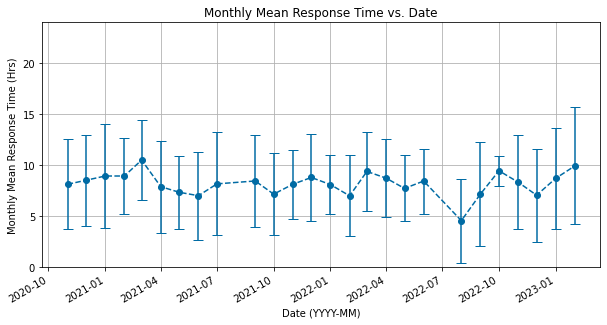

In [45]:
def response_time_summary():
    df = pd.read_pickle(f'{data_dir}/response_time_monthly_stats.pkl')
    fig, ax = plt.subplots(figsize=(10,5))
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plot = ax.scatter(df['date'], df['mean_response'], c=df['std_response'] 'o--')
    ax.set_title(f'Monthly Mean Response Time vs. Date')
    ax.set_ylabel('Monthly Mean Response Time (Hrs)')
    ax.set_ylim(0, 24)
    ax.set_xlabel('Date (YYYY-MM)')
    ax.grid(True)
    fig.autofmt_xdate()
    fig.colorbar(plot, ax=ax, cmap='cividis')
    directory = f'doc/nb/time_plots/response_time/summary'
    if not os.path.isdir(directory):
        os.makedirs(directory)
    plt.savefig(f'{directory}/response_time_summary.png')
    plt.show()
    plt.close(fig)
    
response_time_summary()

In [ ]:
from datetime import datetime

def distributions_over_time(daytime):
    folder = 'daytime' if daytime else 'nighttime'
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    std_temps1 = np.linspace(-10, 30, 4001)
    std_temps2 = np.linspace(-20, 20, 4001)
    
    with open(f'{data_dir}/ambient_distributions_{folder}.pkl', 'rb') as pf:
        ambient = pd.read_pickle(pf)
    with open(f'{data_dir}/delta_distributions_{folder}.pkl', 'rb') as pf:
        delta = pd.read_pickle(pf)
    
    ambient_distr = []
    ambient_times = []
    delta_distr = []
    delta_times = []
    for i in years:
        for j in tqdm(months, desc=f'{i}'):
            if len(ambient[i][j]):
                ambient[i][j] = [k for k in ambient[i][j] if not (k != k) ]
                if len(ambient[i][j]):
                    ambient_distr.append(skewnorm.pdf(std_temps1, *skewnorm.fit(ambient[i][j])))
                    ambient_times.append(f'{i}-{j}')
            if len(delta[i][j]):
                delta[i][j] = [k for k in delta[i][j] if not (k != k) ]
                if len(delta[i][j]):
                    delta_distr.append(skewnorm.pdf(std_temps2, *skewnorm.fit(delta[i][j])))
                    delta_times.append(f'{i}-{j}')

    ambient_distr = np.asarray(ambient_distr)
    ambient_times = np.asarray(ambient_times)
    delta_distr = np.asarray(delta_distr)
    delta_times = np.asarray(delta_times)

    temp_nums = np.linspace(1, len(ambient_times), len(ambient_times))
    XX, YY = np.meshgrid(temp_nums, std_temps1)

    ax = plt.figure().add_subplot(projection='3d')
    ax.view_init(60, 15)
    surf = ax.plot_surface(XX, YY, ambient_distr.T, cmap=cm.plasma, lw=0.5, rstride=8, cstride=8)
    fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax)
    ax.set_title('Ambient Temperature Distribution as a Function of Time')
    ax.set_xlabel('Date')
    ax.set_ylabel(u'Ambient Temperature (\u2103)')
    ax.set_zlabel('Density (%)')
    
    ax.set_xticks([temp_nums[0], temp_nums[len(temp_nums)//4], temp_nums[len(temp_nums)//2], temp_nums[3*len(temp_nums)//4], temp_nums[-1]]) 
    ax.set_xticklabels([ambient_times[0], ambient_times[len(ambient_times)//4], ambient_times[len(ambient_times)//2], ambient_times[3*len(ambient_times)//4], ambient_times[-1]])
    
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.savefig(f'time_plots/temp_distributions/ambient_distribution_{folder}.png')
    plt.show()

    temp_nums = np.linspace(1, len(delta_times), len(delta_times))
    XX, YY = np.meshgrid(temp_nums, std_temps2)

    ax = plt.figure().add_subplot(projection='3d')
    ax.view_init(45, 35)
    surf = ax.plot_surface(XX, YY, delta_distr.T, cmap=cm.plasma, lw=0.5, rstride=8, cstride=8)
    fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax)
    ax.set_title('Temperature Delta Distribution as a Function of Time')
    ax.set_xlabel('Date')
    ax.set_ylabel(u'Temperature Delta (\u2103)')
    ax.set_zlabel('Density (%)')
    
    ax.set_xticks([temp_nums[0], temp_nums[len(temp_nums)//4], temp_nums[len(temp_nums)//2], temp_nums[3*len(temp_nums)//4], temp_nums[-1]]) 
    ax.set_xticklabels([delta_times[0], delta_times[len(delta_times)//4], delta_times[len(delta_times)//2], delta_times[3*len(delta_times)//4], delta_times[-1]])
    
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.savefig(f'time_plots/temp_distributions/delta_distribution_{folder}.png')
    plt.show()


In [ ]:
distributions_over_time(daytime=True)
# distributions_over_time(daytime=False)

In [ ]:
def resample_data(df):
    """Resamples DESI telemetry data contained within Pandas dataframe.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Original data as queried from the DESI telemetry database
    
    Returns
    -------
    df : pandas.DataFrame
        Resampled and interpolated DESI telemetry data
    """
    if 'seeing' in df.columns.values:
        pass
    else:
        df = df.resample('6S').mean()
        df.interpolate(limit_direction='both', inplace=True)
    df = df.tz_convert("America/Phoenix")
    return df

In [ ]:
daytime=True
folder = 'daytime' if daytime else 'nighttime'
with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
    temp_delta_data = pickle.load(pf)
directory = f'time_plots/temp_statistics/{folder}'
if not os.path.isdir(directory):
    os.makedirs(directory)

fig, ax = plt.subplots(figsize=(20,5))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['figure.facecolor'] = 'white'
ax.set_title('Response Time (Hrs) vs Initial Ambient Temperature')
ax.set_ylabel('Response Time (Hrs)')
ax.set_xlabel('Initial Ambient Temperature')
ax.autoscale(True)
plt.grid(True)

x, y = temp_delta_data['ambient_start'].to_numpy(dtype=np.float64), temp_delta_data['response_time'].to_numpy(dtype=np.float64)

CovM = np.cov(np.stack((x,y), axis=0))
bounds = np.sqrt(CovM.diagonal())

# Get eigenvalue/vector using svd
eigvec, eigval, u = np.linalg.svd(CovM)
print
# Get Semimajor/minor axes of the ellipse
semimaj = np.sqrt(eigval[0])*2.
semimin = np.sqrt(eigval[1])*2.

# Rotation angle of the ellipse
theta = np.arctan(eigvec[0][1]/eigvec[0][0])

# Create ellipses
ell = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = '68% confidence')
ell2 = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

ax.add_patch(ell2)
ax.add_patch(ell)
ax.scatter(x, y, c='maroon')
plt.legend()
fig.savefig(f'{directory}/response_time_vs_initial_ambient_temp.png')
plt.show()
# plt.close(fig)

In [ ]:
daytime=True
folder = 'daytime' if daytime else 'nighttime'
with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
    temp_delta_data = pickle.load(pf)
directory = f'time_plots/temp_statistics/{folder}'
if not os.path.isdir(directory):
    os.makedirs(directory)

fig, ax = plt.subplots(figsize=(20,5))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['figure.facecolor'] = 'white'
ax.set_title('Response Time (Hrs) vs Final Ambient Temperature')
ax.set_ylabel('Response Time (Hrs)')
ax.set_xlabel('Final Ambient Temperature')
ax.autoscale(True)
plt.grid(True)

x, y = temp_delta_data['ambient_end'].to_numpy(dtype=np.float64), temp_delta_data['response_time'].to_numpy(dtype=np.float64)

CovM = np.cov(np.stack((x,y), axis=0))
bounds = np.sqrt(CovM.diagonal())

# Get eigenvalue/vector using svd
eigvec, eigval, u = np.linalg.svd(CovM)
print
# Get Semimajor/minor axes of the ellipse
semimaj = np.sqrt(eigval[0])*2.
semimin = np.sqrt(eigval[1])*2.

# Rotation angle of the ellipse
theta = np.arctan(eigvec[0][1]/eigvec[0][0])

# Create ellipses
ell = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = '68% confidence')
ell2 = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

ax.add_patch(ell2)
ax.add_patch(ell)
ax.scatter(x, y, c='maroon')
plt.legend()
fig.savefig(f'{directory}/response_time_vs_final_ambient_temp.png')
plt.show()
# plt.close(fig)

In [ ]:
daytime=False
folder = 'daytime' if daytime else 'nighttime'
with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
    temp_delta_data = pickle.load(pf)
directory = f'time_plots/temp_statistics/{folder}'
if not os.path.isdir(directory):
    os.makedirs(directory)

fig, ax = plt.subplots(figsize=(20,5))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['figure.facecolor'] = 'white'
ax.set_title('Response Time (Hrs) vs Final Temperature Delta')
ax.set_ylabel('Response Time (Hrs)')
ax.set_xlabel('Final Temperature Delta')
ax.autoscale(True)
plt.grid(True)

x, y = temp_delta_data['end'].to_numpy(dtype=np.float64), temp_delta_data['response_time'].to_numpy(dtype=np.float64)

CovM = np.cov(np.stack((x,y), axis=0))
bounds = np.sqrt(CovM.diagonal())

# Get eigenvalue/vector using svd
eigvec, eigval, u = np.linalg.svd(CovM)
print
# Get Semimajor/minor axes of the ellipse
semimaj = np.sqrt(eigval[0])*2.
semimin = np.sqrt(eigval[1])*2.

# Rotation angle of the ellipse
theta = np.arctan(eigvec[0][1]/eigvec[0][0])

# Create ellipses
ell = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = '68% confidence')
ell2 = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

ax.add_patch(ell2)
ax.add_patch(ell)
ax.axvline(x=1.5, c='r', linestyle='--')
ax.axvline(x=-1.5, c='r', linestyle='--')
ax.scatter(x, y, c='maroon')
plt.legend()
fig.savefig(f'{directory}/response_time_vs_final_temp_delta.png')
plt.show()
# plt.close(fig)

In [ ]:
daytime=True
folder = 'daytime' if daytime else 'nighttime'
with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
    temp_delta_data = pickle.load(pf)
directory = f'time_plots/temp_statistics/{folder}'
if not os.path.isdir(directory):
    os.makedirs(directory)

fig, ax = plt.subplots(figsize=(20,5))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['figure.facecolor'] = 'white'
ax.set_title('Response Time (Hrs) vs Initial Temperature Delta')
ax.set_ylabel('Response Time (Hrs)')
ax.set_xlabel('Initial Temperature Delta')
ax.autoscale(True)
plt.grid(True)

x, y = temp_delta_data['start'].to_numpy(dtype=np.float64), temp_delta_data['response_time'].to_numpy(dtype=np.float64)

CovM = np.cov(np.stack((x,y), axis=0))
bounds = np.sqrt(CovM.diagonal())

# Get eigenvalue/vector using svd
eigvec, eigval, u = np.linalg.svd(CovM)
print
# Get Semimajor/minor axes of the ellipse
semimaj = np.sqrt(eigval[0])*2.
semimin = np.sqrt(eigval[1])*2.

# Rotation angle of the ellipse
theta = np.arctan(eigvec[0][1]/eigvec[0][0])

# Create ellipses
ell = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = '68% confidence')
ell2 = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

ax.add_patch(ell2)
ax.add_patch(ell)
ax.axvline(x=1.5, c='r', linestyle='--')
ax.axvline(x=-1.5, c='r', linestyle='--')
ax.scatter(x, y, c='maroon')
plt.legend()
fig.savefig(f'{directory}/response_time_vs_final_temp_delta.png')
plt.show()
# plt.close(fig)

In [ ]:
daytime=False
folder = 'daytime' if daytime else 'nighttime'
with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
    temp_delta_data = pickle.load(pf)
directory = f'time_plots/temp_statistics/{folder}'
if not os.path.isdir(directory):
    os.makedirs(directory)

fig, ax = plt.subplots(figsize=(20,5))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['figure.facecolor'] = 'white'
ax.set_title('Response Time (Hrs) vs Initial Temperature Delta')
ax.set_ylabel('Response Time (Hrs)')
ax.set_xlabel('Initial Temperature Delta')
ax.autoscale(True)
plt.grid(True)

# x, y = np.array(temp_delta_data.index, dtype=np.datetime64), temp_delta_data['response_time'].to_numpy(dtype=object)

# CovM = np.cov(np.stack((x,y), axis=0))
# bounds = np.sqrt(CovM.diagonal())

# # Get eigenvalue/vector using svd
# eigvec, eigval, u = np.linalg.svd(CovM)
# print
# # Get Semimajor/minor axes of the ellipse
# semimaj = np.sqrt(eigval[0])*2.
# semimin = np.sqrt(eigval[1])*2.

# # Rotation angle of the ellipse
# theta = np.arctan(eigvec[0][1]/eigvec[0][0])

# # Create ellipses
# ell = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = '68% confidence')
# ell2 = mpl.patches.Ellipse(xy=[np.mean(x), np.mean(y)], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

# ax.add_patch(ell2)
# ax.add_patch(ell)
# ax.axvline(x=1.5, c='r', linestyle='--')
# ax.axvline(x=-1.5, c='r', linestyle='--')
ax.scatter(x, y, c='maroon')
plt.legend()
# fig.savefig(f'{directory}/response_time_vs_initial_temp_delta.png')
plt.show()
# plt.close(fig)

In [ ]:
def yearly_delta_stats(daytime=True):
    folder = 'daytime' if daytime else 'nighttime'
    with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
        temp_delta_data = pickle.load(pf)
    directory = f'time_plots/temp_statistics/{folder}'
    if not os.path.isdir(directory):
        os.makedirs(directory)

    fig, ax = plt.subplots(figsize=(20,15))
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    ax.set_title('Daily Temperature Statistics vs. Date/Time')
    ax.set_xlabel('Day')
    ax.autoscale(True)
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['mins'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  minimum')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['maxs'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  maximum')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['mean'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  mean')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['median'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  median')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['std'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  standard deviation')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['var'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta variance')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['start'].iloc[no_outliers][valid], 'o--', markersize=5, label='initial temp delta')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['end'].iloc[no_outliers][valid], 'o--', markersize=5, label='final temp delta')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_start'].iloc[no_outliers][valid], 'o--', markersize=5, label='initial ambient temp')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_end'].iloc[no_outliers][valid], 'o--', markersize=5, label='final ambient temp')
    ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_at_response'].iloc[no_outliers][valid], 'o--', markersize=5, label='ambient temp at equilbrium')
    ax_handles, _ = ax.get_legend_handles_labels()
    twin = ax.twinx()
    twin.set_ylabel('Hours For Temperature To Equalize')
    twin.autoscale(True)
    twin.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['response_time'].iloc[no_outliers][valid], 'o--', markersize=5, c='maroon', label='time to reach equilbrium')
    twin_handles, _ = twin.get_legend_handles_labels()
    ax.legend(handles=ax_handles+twin_handles)
    
    fig.savefig(f'{directory}/{i}-{j}.png')
    plt.close(fig)

In [29]:
from scipy import stats
# removes results outside of 5 std
def remove_outliers(data):
    return np.logical_and(np.abs(stats.zscore(np.asarray(data))) < 10, np.isfinite(np.asarray(data)))

In [ ]:
def yearly_delta_stats(daytime=True):
    folder = 'daytime' if daytime else 'nighttime'
    with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
        temp_delta_data = pickle.load(pf)
    directory = f'time_plots/temp_statistics/{folder}'
    if not os.path.isdir(directory):
        os.makedirs(directory)
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    no_outliers = remove_outliers(temp_delta_data['mean'])
    for i in years:
        for j in months:
            valid = np.argwhere(np.logical_and(temp_delta_data.index[no_outliers].year == i, temp_delta_data.index[no_outliers].month == j)).flatten()
            if len(valid):
                fig, ax = plt.subplots(figsize=(20,15))
                plt.rcParams['axes.facecolor']='white'
                plt.rcParams['savefig.facecolor']='white'
                plt.rcParams['figure.facecolor'] = 'white'
                ax.set_title('Daily Temperature Statistics vs. Date/Time')
                ax.set_xlabel('Day')
                ax.autoscale(True)
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['mins'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  minimum')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['maxs'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  maximum')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['mean'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  mean')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['median'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  median')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['std'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta  standard deviation')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['var'].iloc[no_outliers][valid], 'o--', markersize=5, label='temp delta variance')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['start'].iloc[no_outliers][valid], 'o--', markersize=5, label='initial temp delta')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['end'].iloc[no_outliers][valid], 'o--', markersize=5, label='final temp delta')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_start'].iloc[no_outliers][valid], 'o--', markersize=5, label='initial ambient temp')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_end'].iloc[no_outliers][valid], 'o--', markersize=5, label='final ambient temp')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_at_response'].iloc[no_outliers][valid], 'o--', markersize=5, label='ambient temp at equilbrium')
                ax_handles, _ = ax.get_legend_handles_labels()
                twin = ax.twinx()
                twin.set_ylabel('Hours For Temperature To Equalize')
                twin.autoscale(True)
                twin.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['response_time'].iloc[no_outliers][valid], 'o--', markersize=5, c='maroon', label='time to reach equilbrium')
                twin_handles, _ = twin.get_legend_handles_labels()
                ax.legend(handles=ax_handles+twin_handles)

                fig.savefig(f'{directory}/{i}-{j}.png')
                plt.close(fig)

In [ ]:
# yearly_delta_stats(daytime=True)
# yearly_delta_stats(daytime=False)

## Single Day Temperature Plots (Night vs Day)

In [ ]:
def new_temperature_plot(year=2022, month=9, day=24, offset=1, save=False):
    start_date = pd.Timestamp(year=year,month=month,day=day,hour=17, minute=0, second=0, microsecond=0, tz="America/Phoenix")-pd.DateOffset(day=1)
    end_date = start_date+pd.DateOffset(day=offset)
    if gpu_access:
        start_date = start_date.to_numpy()
        end_date = end_date.to_numpy()

    print(f'Start date: {start_date}')
    print(f'Offset length (# of days): {offset}')
    
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax0_plots = []
    ax1_plots = []
    ax[0].autoscale(True)
    ax[0].set_title('Mirror Temperature & Seeing vs. Date/Time')
    ax[0].set_ylabel('Mirror Temperature (Celcius)')
    ax[0].set_xlabel('Date/Time')
    ax[1].autoscale(True)
    ax[1].set_title('Dome & Tower Temperature vs. Date/Time')
    ax[1].set_ylabel('Dome Temperature (Celcius)')
    ax[1].set_xlabel('Date/Time')

    if gpu_access:
        telescope_indicies = cp.argwhere(cp.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()
    else:
        telescope_indicies = np.argwhere(np.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()
    temp_delta = remove_outliers(telescope_data.iloc[telescope_indicies]['air_temp']-telescope_data.iloc[telescope_indicies]['mirror_temp'])
    print(f'Number of valid telescope environment samples in current time window: {len(telescope_indicies)}')
    if len(telescope_indicies):
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_avg_temp'], label='average mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_temp'], label='mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_desired_temp'], label='desired mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['air_temp'], label='air temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_cooling'], label='mirror cooling')[0])
        ax0_plots.append(ax[0].plot(temp_delta.index, temp_delta, label='temp delta')[0])
        ax[0].axhline(y=1.5, color='maroon', linestyle='--')
        ax[0].axhline(y=-1.5, color='maroon', linestyle='--')
        ax[0].annotate(u"1.5 \u2103", xy=(end_date, 1.75), annotation_clip=False, ha='right')
        ax[0].annotate(u"-1.5 \u2103", xy=(end_date, -1.25), annotation_clip=False, ha='right')

    if gpu_access:
        telemetry_indicies = cp.argwhere(cp.logical_and(telemetry_data.index >= start_date, telemetry_data.index <= end_date)).flatten()
    else:
        telemetry_indicies = np.argwhere(np.logical_and(telemetry_data.index >= start_date, telemetry_data.index <= end_date)).flatten()
    print(f'Number of valid etc telemetry samples in current time window: {len(telemetry_indicies)}')
    if len(telemetry_indicies):
        twin0 = ax[0].twinx()
        ax0_plots.append(twin0.plot(telemetry_data.index[telemetry_indicies], telemetry_data.iloc[telemetry_indicies]['seeing'], color="indigo", label='seeing')[0])
        twin0.autoscale(True)
        twin0.set_ylabel('Seeing')

    if gpu_access:
        dome_indicies = cp.argwhere(cp.logical_and(dome_data.index >= start_date, dome_data.index <= end_date)).flatten()
    else:
        dome_indicies = np.argwhere(np.logical_and(dome_data.index >= start_date, dome_data.index <= end_date)).flatten()
    print(f'Number of valid dome environment samples in current time window: {len(dome_indicies)}')
    if len(dome_indicies):
        ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_ne'], label='dome floor temp (NE)')[0])
        ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_nw'], label='dome floor temp (NW)')[0])
        ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_s'], label='dome floor temp (S)')[0])

    if gpu_access:
        tower_indicies = cp.argwhere(cp.logical_and(tower_data.index >= start_date, tower_data.index <= end_date)).flatten()
    else:
        tower_indicies = np.argwhere(np.logical_and(tower_data.index >= start_date, tower_data.index <= end_date)).flatten()
    print(f'Number of valid tower environment samples in current time window: {len(tower_indicies)}')
    if len(tower_indicies):
        twin1 = ax[1].twinx()
        ax1_plots.append(twin1.plot(tower_data.index[tower_indicies], tower_data.iloc[tower_indicies]['temperature'], color="indigo", label='tower temp')[0])
        twin1.autoscale(True)
        twin1.set_ylabel('Tower Temperature (Celcius)')
    
    if ax1_plots:
        ax[1].legend(handles=ax1_plots)
    else:
        ax[1].remove()

    if ax0_plots:
        ax[0].legend(handles=ax0_plots)
        if save:
            plt.savefig(f'time_plots/with_temp_delta/{year}-{month}-{day}_{offset}-day-offset.png', format='png')
        plt.show()
    else:
        print("Insufficient data in this time window!")

In [39]:
def get_time_ranges(cooling_on):
    changes = telescope_data['mirror_cooling'][1:].to_numpy()-telescope_data['mirror_cooling'][:len(telescope_data)-1].to_numpy()
    changes = changes[valid_values(telescope_data['air_temp'][:-1])]
    ranges = []
    start=0
    for i in range(len(changes)):
        if cooling_on:
            if changes[i] == 1:
                start = i
            elif changes[i] == -1:
                end = i
                ranges.append(np.linspace(start+1, end, end-start, dtype=np.int64))
        else:
            if changes[i] == -1:
                start = i
            elif changes[i] == 1:
                end = i
                ranges.append(np.linspace(start+1, end, end-start, dtype=np.int64))
    return ranges

In [43]:
def temp_delta_stats(daytime=True):
    file = 'daytime' if daytime else 'nighttime'
    time_ranges = get_time_ranges(cooling_on=daytime)
    mirror_ambient_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    mirror_desired_delta = telescope_data['mirror_desired_temp']-telescope_data['mirror_temp']
    delta_min = []
    delta_max = []
    delta_mean = []
    delta_median = []
    delta_std = []
    delta_var = []
    delta_start = []
    delta_end = []
    ambient_min = []
    ambient_max = []
    ambient_mean = []
    ambient_median = []
    ambient_std = []
    ambient_var = []
    ambient_start = []
    ambient_end = []
    start_time = []
    response_time = []
    ambient_response = []
    for i in trange(len(time_ranges), desc=f'{file} statistics'):
        delta_min.append(mirror_ambient_delta.iloc[time_ranges[i]].min())
        delta_max.append(mirror_ambient_delta.iloc[time_ranges[i]].max())
        delta_mean.append(mirror_ambient_delta.iloc[time_ranges[i]].mean())
        delta_median.append(mirror_ambient_delta.iloc[time_ranges[i]].median())
        delta_std.append(mirror_ambient_delta.iloc[time_ranges[i]].std())
        delta_var.append(mirror_ambient_delta.iloc[time_ranges[i]].var())
        delta_start.append(mirror_ambient_delta.iloc[time_ranges[i][0]])
        delta_end.append(mirror_ambient_delta.iloc[time_ranges[i][-1]])
        ambient_min.append(telescope_data['air_temp'].iloc[time_ranges[i]].min())
        ambient_max.append(telescope_data['air_temp'].iloc[time_ranges[i]].max())
        ambient_mean.append(telescope_data['air_temp'].iloc[time_ranges[i]].mean())
        ambient_median.append(telescope_data['air_temp'].iloc[time_ranges[i]].median())
        ambient_std.append(telescope_data['air_temp'].iloc[time_ranges[i]].std())
        ambient_var.append(telescope_data['air_temp'].iloc[time_ranges[i]].var())
        ambient_start.append(telescope_data['air_temp'].iloc[time_ranges[i]][0])
        ambient_end.append(telescope_data['air_temp'].iloc[time_ranges[i]][-1])
        start_time.append(mirror_ambient_delta.index[time_ranges[i]][0])
        equalize = np.argwhere(np.abs(mirror_ambient_delta.iloc[time_ranges[i]].to_numpy()<1e-1)).flatten()
        if len(equalize):
            time = (mirror_ambient_delta.index[time_ranges[i]][equalize[-1]]-mirror_ambient_delta.index[time_ranges[i]][0]).seconds/3600
            response_time.append(time)
            ambient_response.append(telescope_data.iloc[time_ranges[i]]['air_temp'][equalize[0]])
        else:
            time = (mirror_ambient_delta.index[time_ranges[i]][-1]-mirror_ambient_delta.index[time_ranges[i]][0]).seconds/3600
            response_time.append(time)
            ambient_response.append(telescope_data.iloc[time_ranges[i]]['air_temp'][-1])
    df = pd.DataFrame()
    df['delta_min'] = delta_min
    df['delta_max'] = delta_max
    df['delta_mean'] = delta_mean
    df['delta_median'] = delta_median
    df['delta_std'] = delta_std
    df['delta_var'] = delta_var
    df['delta_start'] = delta_start
    df['delta_end'] = delta_end
    df['ambient_min'] = ambient_min
    df['ambient_max'] = ambient_max
    df['ambient_mean'] = ambient_mean
    df['ambient_median'] = ambient_median
    df['ambient_std'] = ambient_std
    df['ambient_var'] = ambient_var
    df['ambient_start'] = ambient_start
    df['ambient_end'] = ambient_end
    df['start_time'] = start_time
    df['response_time'] = response_time
    df['ambient_response'] = ambient_response
    df.set_index('start_time', inplace=True)
    with open(f'{data_dir}/temp_delta_stats_{file}.pkl', 'wb') as pf:
        pickle.dump(df, pf)

In [54]:
# temp_delta_stats(daytime=True)
# temp_delta_stats(daytime=False)

daytime statistics:   0%|          | 0/719 [00:00<?, ?it/s]

In [ ]:
def mirror_cooling_plots(daytime=False):
    time_ranges = get_time_ranges(cooling_on=daytime)
    mirror_ambient_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    mirror_desired_delta = telescope_data['mirror_desired_temp']-telescope_data['mirror_temp']
    folder = 'daytime' if daytime else 'nighttime'

    for i in trange(len(time_ranges), desc=f'{folder} single day plots'):
                
        fig, ax = plt.subplots(ncols=2, figsize=(20,10))
        ax0_plots = []
        ax1_plots = []
        ax[0].autoscale(True)
        ax[0].set_title('Mirror Temperature vs. Date/Time')
        ax[0].set_ylabel('Mirror Temperature (Celcius)')
        ax[0].set_xlabel('Date/Time')
        ax[1].autoscale(True)
        ax[1].set_title('Dome & Tower Temperature vs. Date/Time')
        ax[1].set_ylabel('Dome Temperature (Celcius)')
        ax[1].set_xlabel('Date/Time')
    
        fig.autofmt_xdate()        

        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_avg_temp'], label='average mirror temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_temp'], label='mirror temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_desired_temp'], label='desired mirror temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['air_temp'], label='air temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_cooling'], label='mirror cooling')
        ax[0].plot(mirror_ambient_delta.index[time_ranges[i]], mirror_ambient_delta.iloc[time_ranges[i]], label='ambient & mirror temp delta')
        ax[0].plot(mirror_desired_delta.index[time_ranges[i]], mirror_desired_delta.iloc[time_ranges[i]], label='desired & mirror temp delta')
        ax[0].axhline(y=1.5, color='maroon', linestyle='--')
        ax[0].axhline(y=-1.5, color='maroon', linestyle='--')
        ax[0].annotate(u"1.5 \u2103", xy=(telescope_data.index[time_ranges[i]][-1], 1.75), annotation_clip=False, ha='right')
        ax[0].annotate(u"-1.5 \u2103", xy=(telescope_data.index[time_ranges[i]][-1], -1.25), annotation_clip=False, ha='right')

        if not daytime:
            telemetry_indicies = np.argwhere(np.logical_and(telemetry_data.index >= telescope_data.index[time_ranges[i]][0], telemetry_data.index <= telescope_data.index[time_ranges[i]][-1])).flatten()
            if len(telemetry_data.iloc[telemetry_indicies]['seeing']):
                twin0 = ax[0].twinx()
                ax[0].set_title('Mirror Temperature & Seeing vs. Date/Time')
                twin0.set_ylabel('Seeing')
                twin0.autoscale(True)
                twin0.plot(telemetry_data.index[telemetry_indicies], telemetry_data.iloc[telemetry_indicies]['seeing'], color="indigo", label='seeing')

        ax[1].plot(dome_data.index[time_ranges[i]], dome_data.iloc[time_ranges[i]]['dome_floor_ne'], label='dome floor temp (NE)')
        ax[1].plot(dome_data.index[time_ranges[i]], dome_data.iloc[time_ranges[i]]['dome_floor_nw'], label='dome floor temp (NW)')
        ax[1].plot(dome_data.index[time_ranges[i]], dome_data.iloc[time_ranges[i]]['dome_floor_s'], label='dome floor temp (S)')

        twin1 = ax[1].twinx()
        twin1.plot(tower_data.index[time_ranges[i]], tower_data.iloc[time_ranges[i]]['temperature'], color="indigo", label='tower temp')
        twin1.autoscale(True)
        twin1.set_ylabel('Tower Temperature (Celcius)')

        ax[0].legend(handles=ax[0].get_legend_handles_labels()+twin0.get_legend_handles_labels())
        ax[1].legend(handles=ax[1].get_legend_handles_labels()+twin1.get_legend_handles_labels())

        year = telescope_data.index[time_ranges[i]][0].year
        month = telescope_data.index[time_ranges[i]][0].month
        day = telescope_data.index[time_ranges[i]][0].day
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.rcParams['figure.facecolor'] = 'white'
        fig.savefig(f'time_plots/single_day_plots/{folder}/{year}-{month}-{day}.png')
        plt.close(fig)

In [ ]:
# mirror_cooling_plots(daytime=True)
# mirror_cooling_plots(daytime=False)

## Monthly Temperature Delta Distributions

In [ ]:
def temp_distribution_data(daytime=True):
    folder = 'daytime' if daytime else 'nighttime'
    time_ranges = get_time_ranges(cooling_on=daytime)[:-1]
    ambient_mirror_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    ambient_mirror_delta = ambient_mirror_delta[remove_outliers(ambient_mirror_delta)]
    ambient_temp = telescope_data['air_temp']
    ambient_temp = ambient_temp[remove_outliers(ambient_temp)]
    print(np.max(ambient_mirror_delta))
    print(np.min(ambient_mirror_delta))
    print(np.max(ambient_temp))
    print(np.min(ambient_temp))
    
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    ambient_distributions = {}
    for i in years:
        year = {}
        for j in months:
            year[j] = []
        ambient_distributions[i] = year
    delta_distributions = deepcopy(ambient_distributions)

    # temps = np.linspace(-20, 20, 4001)
    # times = np.empty((len(time_ranges)), dtype=type(ambient_temp.index[0]))
    # ambient_distributions = np.empty((len(time_ranges), len(temps)), dtype=np.float64)
    # delta_distributions = np.empty((len(time_ranges), len(temps)), dtype=np.float64)
    for i in trange(len(time_ranges), desc=f'{folder}'):
        # time = time_ranges[i] if len(time_ranges[i]) else [time_ranges[i]]
        # print(time)
        # try:
        #     assert(np.max(time)<len(ambient_temp))
        #     assert(np.max(time)<len(ambient_mirror_delta))
        # except AssertionError:
        #     print(np.max(time), len(ambient_temp))
        #     print(np.max(time), len(ambient_mirror_delta))
        # times[i] = ambient_temp.index[time_ranges[i][0]].date()
        # ambient_distributions[i] = skewnorm.pdf(temps, *skewnorm.fit(ambient_temp.iloc[time_ranges[i]]))
        # delta_distributions[i] = skewnorm.pdf(temps, *skewnorm.fit(ambient_mirror_delta.iloc[time_ranges[i]]))
        if (np.nan not in ambient_temp.iloc[i]) and (ambient_mirror_delta.iloc[i] is not np.nan):
            ambient_distributions[ambient_temp.index[i].year][ambient_temp.index[i].month].append(ambient_temp.iloc[i])
            delta_distributions[ambient_mirror_delta.index[i].year][ambient_mirror_delta.index[i].month].append(ambient_mirror_delta.iloc[i])
    with open(f'{data_dir}/ambient_distributions_{folder}.pkl', 'wb') as pf:
        pickle.dump(ambient_distributions, pf)
    with open(f'{data_dir}/delta_distributions_{folder}.pkl', 'wb') as pf:
        pickle.dump(delta_distributions, pf)
    with open(f'{data_dir}/full_distributions_{folder}.pkl', 'wb') as pf:
        full_distributions = [temps, times, ambient_distributions, delta_distributions]
        pickle.dump(full_distributions, pf)


In [ ]:
# temp_distribution_data(daytime=True)
# temp_distribution_data(daytime=False)

In [22]:
from scipy.stats import skewnorm, norm
from astropy.stats import scott_bin_width
from math import trunc, ceil, floor
from matplotlib import cm
from pandas.io.json._normalize import nested_to_record    

def FWHM(x, y):
    deltax = x[1] - x[0]
    half_max = max(y) / 2.
    l = np.where(y > half_max, 1, 0)
    return np.sum(l) * deltax

def monthly_delta_distribution(daytime=True):
    mpl.style.use('tableau-colorblind10')
    folder = 'daytime' if daytime else 'nighttime'
    with open(f'{data_dir}/ambient_distributions_{folder}.pkl', 'rb') as pf:
        ambient_distributions = pickle.load(pf)
    with open(f'{data_dir}/delta_distributions_{folder}.pkl', 'rb') as pf:
        delta_distributions = pickle.load(pf)
    with open(f'{data_dir}/temp_delta_stats_{folder}.pkl', 'rb') as pf:
        temp_delta_data = pickle.load(pf)
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)

    temp_stats = {}
    for i in years:
        year = {}
        for j in months:
            year[j] = []
        temp_stats[i] = year
    for i in range(len(temp_delta_data)):
        temp_stats[temp_delta_data.index[i].year][temp_delta_data.index[i].month].append(temp_delta_data.iloc[i])


    ambient_mirror_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    ambient_mirror_delta = ambient_mirror_delta[valid_values(ambient_mirror_delta)]
    ambient_temp = telescope_data['air_temp'][valid_values(telescope_data['air_temp'])]
    
    ambient_min = floor(np.min(ambient_temp))
    ambient_max = ceil(np.max(ambient_temp))
    delta_min = floor(np.min(ambient_mirror_delta))
    delta_max = ceil(np.max(ambient_mirror_delta))
    
    vmin = temp_delta_data['ambient_std'][valid_values(temp_delta_data['ambient_std'])].min()
    vmax = temp_delta_data['ambient_std'][valid_values(temp_delta_data['ambient_std'])].max()
    
    xmin_start = temp_delta_data['delta_start'][valid_values(temp_delta_data['delta_start'])].min()
    xmax_start = temp_delta_data['delta_start'][valid_values(temp_delta_data['delta_start'])].max()
    ymin_start = temp_delta_data['ambient_start'][valid_values(temp_delta_data['ambient_start'])].min()
    ymax_start = temp_delta_data['ambient_start'][valid_values(temp_delta_data['ambient_start'])].max()
    
    xmin_end = temp_delta_data['delta_end'][valid_values(temp_delta_data['delta_end'])].min()
    xmax_end = temp_delta_data['delta_end'][valid_values(temp_delta_data['delta_end'])].max()
    ymin_end = temp_delta_data['ambient_end'][valid_values(temp_delta_data['ambient_end'])].min()
    ymax_end = temp_delta_data['ambient_end'][valid_values(temp_delta_data['ambient_end'])].max()

    percent_ideal_data = []    
    percent_ideal_time = []
    width_delta = []
    width_ambient = []
        
    for i in years:
        directory = f'time_plots/temp_distributions/{folder}/{i}'
        for j in tqdm(months, desc=f'{i}'):
            delta_arr = np.asarray(delta_distributions[i][j])[valid_values(delta_distributions[i][j])]
            ambient_arr = np.asarray(ambient_distributions[i][j])[valid_values(ambient_distributions[i][j])]
            if len(delta_arr) and len(ambient_arr):
                df = pd.DataFrame(temp_stats[i][j])
                if 'delta_start' and 'delta_end' and 'ambient_start' and 'ambient_end' in df.columns.values:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
                    plt.rcParams['axes.facecolor']='white'
                    plt.rcParams['savefig.facecolor']='white'
                    plt.rcParams['figure.facecolor'] = 'white'

                    percent_ideal = 100*np.count_nonzero(np.abs(delta_arr) < 1.5)/len(delta_arr)
                    percent_ideal_data.append(percent_ideal)
                    percent_ideal_time.append(pd.Timestamp(year=i,month=j,day=1))
                    
                    bins = ceil(np.ptp(delta_arr)/scott_bin_width(delta_arr))
                    # bins = ceil(4*np.ptp(ambient_arr))
                    ax[0][0].hist(delta_arr, bins=bins, density=True, label='histogram')
                    xs = np.linspace(delta_min, delta_max, 1000*(delta_max-delta_min)+1)
                    ys = norm.pdf(xs, *norm.fit(delta_arr))
                    width_delta.append(FWHM(xs,ys))
                    ax[0][0].scatter(xs, ys, 5, color=next(ax[0][0]._get_lines.prop_cycler)['color'], marker='.', label=f'Guassian fit (FWHM: {FWHM(xs,ys):.2f})')
                    ax[0][0].axvline(x=1.5, c='black', linestyle='--', label=u'\u00b1 1.5 \u2103 window ' + f'({percent_ideal:.2f}% inside)')
                    ax[0][0].axvline(x=-1.5, c='black', linestyle='--')
                    ax[0][0].set_title(f'Distribution of Ambient-Mirror Temperatuere Delta ({i}-{j})')
                    ax[0][0].set_ylabel('Density (%)')
                    ax[0][0].set_ylim(0, 1.0)
                    ax[0][0].set_xlabel(u'Temperature Delta (\u2103)')
                    ax[0][0].legend()

                    bins = ceil(np.ptp(ambient_arr)/scott_bin_width(ambient_arr))
                    # bins = ceil(4*np.ptp(ambient_arr))
                    ax[0][1].hist(ambient_arr, bins=bins, density=True, label='histogram')
                    xs = np.linspace(ambient_min, ambient_max, 1000*(ambient_max-ambient_min)+1)
                    ys = norm.pdf(xs, *norm.fit(ambient_arr))
                    width_ambient.append(FWHM(xs,ys))
                    ax[0][1].scatter(xs, ys, 5, color=next(ax[0][1]._get_lines.prop_cycler)['color'], marker='.', label=f'Guassian fit (FWHM: {FWHM(xs,ys):.2f})')
                    ax[0][1].set_title(f'Distribution of Ambient Temperature ({i}-{j})')
                    ax[0][1].set_ylabel('Density (%)')
                    ax[0][1].set_ylim(0, 1.0)
                    ax[0][1].set_xlabel(u'Ambient Temperature (\u2103)')
                    ax[0][1].legend()

                    indx = np.logical_and(valid_values(df['ambient_std']), np.logical_and(valid_values(df['ambient_start']), valid_values(df['delta_start'])))
                    scatter1 = ax[1][0].scatter(df['delta_start'][indx], df['ambient_start'][indx], c=df['ambient_std'][indx], cmap='cividis', vmin=vmin, vmax=vmax)
                    ax[1][0].set_title(f'Initial Ambient Temperature vs Initial Temperature Delta ({i}-{j})')
                    ax[1][0].set_ylabel(u'Initial Ambient Temperature (\u2103)')
                    ax[1][0].set_xlim(xmin_start, xmax_start)
                    ax[1][0].set_xlabel(u'Initial Temperature Delta (\u2103)')
                    ax[1][0].set_ylim(ymin_start, ymax_start)
                    ax[1][0].grid(True)
                    fig.colorbar(scatter1, ax=ax[1][0], label=u'Standard Deviation of Ambient Temperature (\u2103)')
                    
                    indx = np.logical_and(valid_values(df['ambient_std']), np.logical_and(valid_values(df['ambient_end']), valid_values(df['delta_end'])))
                    scatter2 = ax[1][1].scatter(df['delta_end'][indx], df['ambient_end'][indx], c=df['ambient_std'][indx], cmap='cividis', vmin=vmin, vmax=vmax)
                    ax[1][1].set_title(f'Final Ambient Temperature vs Final Temperature Delta ({i}-{j})')
                    ax[1][1].set_ylabel(u'Final Ambient Temperature (\u2103)')
                    ax[1][1].set_ylim(ymin_end, ymax_end)
                    ax[1][1].set_xlabel(u'Final Temperature Delta (\u2103)')
                    ax[1][1].set_xlim(xmin_end, xmax_end)
                    ax[1][1].grid(True)
                    fig.colorbar(scatter2, ax=ax[1][1], label=u'Standard Deviation of Ambient Temperature (\u2103)')

                    fig.savefig(f'{directory}/{i}-{j}.png', format='png') 
                    plt.close(fig)
    
    df = pd.DataFrame()
    df['percent_ideal'] = percent_ideal_data
    df['time'] = percent_ideal_time
    df['width_delta'] = width_delta
    df['width_ambient'] = width_ambient
    with open(f'{data_dir}/distr_summary_data_{folder}.pkl', 'wb') as pf:
        pickle.dump(df, pf)

In [210]:
monthly_delta_distribution(daytime=True)
monthly_delta_distribution(daytime=False)

2019:   0%|          | 0/12 [00:00<?, ?it/s]

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1

2020:   0%|          | 0/12 [00:00<?, ?it/s]

2021:   0%|          | 0/12 [00:00<?, ?it/s]

2022:   0%|          | 0/12 [00:00<?, ?it/s]

2023:   0%|          | 0/12 [00:00<?, ?it/s]

2019:   0%|          | 0/12 [00:00<?, ?it/s]

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1

2020:   0%|          | 0/12 [00:00<?, ?it/s]

2021:   0%|          | 0/12 [00:00<?, ?it/s]

2022:   0%|          | 0/12 [00:00<?, ?it/s]

2023:   0%|          | 0/12 [00:00<?, ?it/s]

In [202]:
def distribution_summary_plots(daytime=False):
    mpl.style.use('tableau-colorblind10')

    folder = 'daytime' if daytime else 'nighttime'
    with open(f'{data_dir}/distr_summary_data_{folder}.pkl', 'rb') as pf:
        df = pickle.load(pf)
    directory = f'time_plots/temp_distributions/{folder}/summary'
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df['time'], df['percent_ideal'], 'o--')
    ax.set_title('Percentage of Time in Ideal Window vs. Date (YYYY-MM)')
    ax.set_ylabel('Percentage of Time in Ideal Window (%)')
    ax.set_ylim(0, 100.0)
    ax.set_xlabel('Date (YYYY-MM)')
    ax.grid(True)
    fig.autofmt_xdate()
    fig.savefig(f'{directory}/percent_ideal_{folder}.png')
    plt.show()
    plt.close(fig)
    
    max = np.max(df['width_delta']) if np.max(df['width_delta']) > np.max(df['width_ambient']) else np.max(df['width_ambient'])
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df['time'], df['width_delta'], 'o--', label='monthly delta distributions')
    ax.plot(df['time'], df['width_ambient'], 'o--', label='monthly ambient distributions')
    ax.set_title('Full Width at Half Max vs. Date')
    ax.set_ylabel(u'Full Width at Half Max (\u2103)')
    ax.set_ylim(0, 15)
    ax.set_xlabel('Date (YYYY-MM)')
    ax.grid(True)
    ax.legend()
    fig.autofmt_xdate()
    fig.savefig(f'{directory}/FWHM_{folder}.png')
    plt.show()
    plt.close(fig)

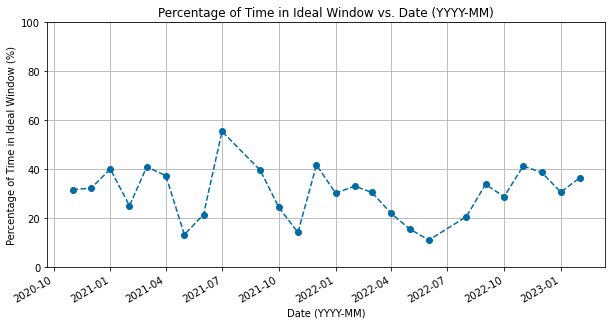

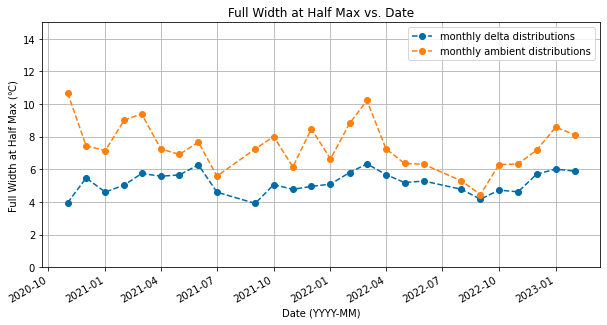

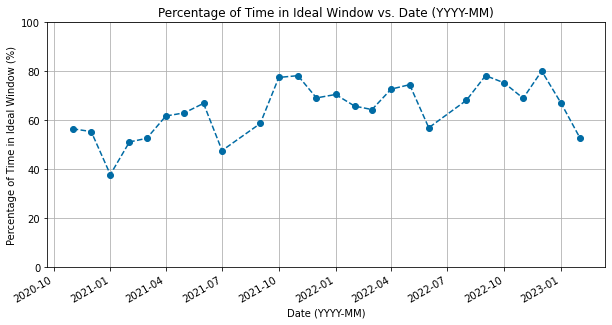

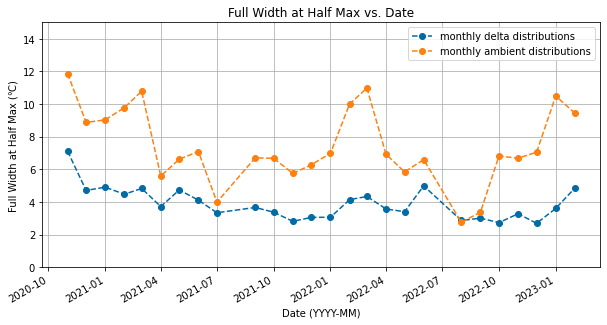

In [203]:
# distribution_summary_plots(daytime=True)
# distribution_summary_plots(daytime=False)

In [ ]:
new_temperature_plot()

In [ ]:
new_temperature_plot(year=2022, month=6, day=10, offset=1, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=10, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=10, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=1, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2021, month=12, day=27, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=21, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2021, month=2, day=1, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=2, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=6, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=7, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=8, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=9, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=10, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=11, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=12, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=3, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=4, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=5, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=15, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2022, month=2, day=1, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=2, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=2, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=3, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=3, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=4, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=4, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=5, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=5, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=7, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=7, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=8, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=8, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=9, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=9, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=10, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=10, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=11, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=11, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=12, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=12, day=15, offset=5, save=True)